In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2, json, itertools, tempfile
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dropout, BatchNormalization, GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import drive
from tensorflow import keras
from keras.models import load_model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import AvgPool2D
from keras.layers import Dense
%load_ext tensorboard

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
g_path = '/content/gdrive'
image_path = g_path + '/My Drive/Colab Notebooks' + '/archive'
image_dir_list = os.listdir(image_path)

print(image_dir_list)

['readme.txt', 'label_map.json', 'test.csv', 'validation.csv', 'train.csv', 'images_train_test_val', 'images']


### Analyse the data and classes

In [ ]:
im_dataset_path = image_path + "/images"
json_file_path = image_path + "/label_map.json"

with open(json_file_path,"r") as j_file:
    class_name_cats = json.load(j_file)

len_classes = len(class_name_cats)
out_classes = list(class_name_cats.keys())
class_name_cats

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19,
 'harbor': 20}

### Load image dataset

In [ ]:
def load_image_data(csv_file):
    images_arr = []
    labels_arr = []
    img_csv = pd.read_csv(csv_file,index_col="Unnamed: 0")

    for i in tqdm(range(img_csv.shape[0])):
        image_name = img_csv.loc[i,'Filename']
        image = load_img(os.path.join(im_dataset_path,image_name),target_size=(224,224))

        image = img_to_array(image)
        image = preprocess_input(image)
        label = img_csv.loc[i,'Label']
        
        images_arr.append(image)
        labels_arr.append(label)
    
    images_arr = np.array(images_arr)
    labels_arr = np.array(labels_arr)
    return images_arr, labels_arr

In [ ]:
train_im_path = image_path + "/train.csv"
val_im_path = image_path + "/validation.csv"
test_im_path = image_path + "/test.csv"

train_imgs, train_classes = load_image_data(train_im_path)
val_imgs, val_classes = load_image_data(val_im_path)
test_imgs, test_classes = load_image_data(test_im_path)

train_imgs.shape, train_classes.shape, val_imgs.shape, val_classes.shape, test_imgs.shape, test_classes.shape

100%|██████████| 1050/1050 [13:31<00:00,  1.29it/s]


((7350, 224, 224, 3),
 (7350,),
 (2100, 224, 224, 3),
 (2100,),
 (1050, 224, 224, 3),
 (1050,))

In [ ]:
train_classes = to_categorical(train_classes)
val_classes = to_categorical(val_classes)
test_classes = to_categorical(test_classes)

print(train_classes.shape)
print(val_classes.shape)
print(test_classes.shape)

(7350, 21)
(2100, 21)
(1050, 21)


### Custom Model

In [ ]:
from keras.regularizers import l2
def RS_CNN():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", bias_regularizer=l2(0.01)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(0.2))
    # model.add(Dense(units=4096,activation="relu"))
    # model.add(Dropout(0.2))
    # model.add(Dense(units=1000,activation="relu"))
    model.add(Dense(units=21, activation="softmax"))

    # Compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])

    return model

### Compile Model

In [ ]:
model = RS_CNN()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 128)     147584    
                                                      

### Plot Model network

In [ ]:
# plot_model(model,to_file='Custom_CNN_model.png',show_shapes=True,show_layer_names=True)
# SVG(model_to_dot(model).create(prog='dot',format='svg'))

### Train Model

In [ ]:
epochs = 40
batchSize = 10

history = model.fit(train_imgs, train_classes,
                      steps_per_epoch=len(train_imgs)//batchSize,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(val_imgs, val_classes),
                      validation_steps=len(val_imgs)//batchSize)
                      # callbacks=[MobileNet_checkpoint, MobileNet_logs])

Epoch 1/40
735/735 [==============================] - 70s 94ms/step - loss: 3.0400 - accuracy: 0.0561 - val_loss: 3.0130 - val_accuracy: 0.0595
Epoch 2/40
735/735 [==============================] - 68s 92ms/step - loss: 2.9381 - accuracy: 0.0869 - val_loss: 2.8330 - val_accuracy: 0.0814
Epoch 3/40
735/735 [==============================] - 68s 92ms/step - loss: 2.7039 - accuracy: 0.1245 - val_loss: 2.6460 - val_accuracy: 0.1543
Epoch 4/40
735/735 [==============================] - 68s 93ms/step - loss: 2.3857 - accuracy: 0.2246 - val_loss: 2.3540 - val_accuracy: 0.2452
Epoch 5/40
735/735 [==============================] - 72s 98ms/step - loss: 2.0724 - accuracy: 0.3216 - val_loss: 2.0140 - val_accuracy: 0.3395
Epoch 6/40
735/735 [==============================] - 68s 92ms/step - loss: 1.8347 - accuracy: 0.3958 - val_loss: 1.8065 - val_accuracy: 0.4138
Epoch 7/40
735/735 [==============================] - 68s 92ms/step - loss: 1.6149 - accuracy: 0.4736 - val_loss: 1.7075 - val_accuracy:

### Show history of traning and validation Accuracy

In [ ]:
def summarize(history):
    
    plt.style.use("ggplot")
    fig, axes = plt.subplots(1,2,figsize=(16,6))

    #Plot loss     
    axes[0].set_title('Cross Entropy Loss')
    axes[0].plot(history.history['loss'], color='blue', label="Train")
    axes[0].plot(history.history['val_loss'], color='orange', label="Validation")
    axes[0].legend(loc='upper right')

    #Plot Accuracy 
    axes[1].set_title('Classification Accuracy')
    axes[1].plot(history.history['accuracy'], color='blue', label="Train")
    axes[1].plot(history.history['val_accuracy'], color='orange', label="Validation")
    axes[1].legend(loc='lower right')
    
    plt.show();
    pass

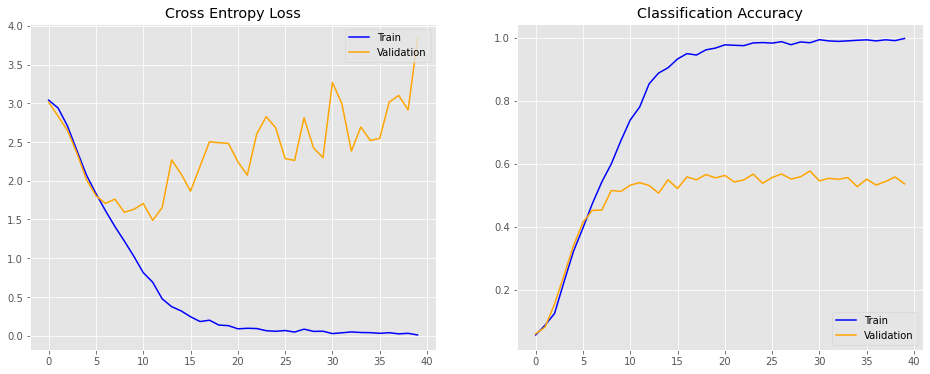

In [ ]:
summarize(history)

### Validation and Confusion Matrix

In [ ]:
def show_conf_matrix(conf_mtx, classes, cmap=plt.cm.Blues):
    
    conf_mtx = conf_mtx.astype('float')/conf_mtx.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(conf_mtx, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    marks = np.arange(len(classes))
    plt.xticks(marks, classes,rotation=90)
    plt.yticks(marks, classes)
    
    fmrt = '.2f'
    limit = conf_mtx.max()/2.0   
    for i,j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j,i, format(conf_mtx[i,j], fmrt),
                horizontalalignment = "center",
                color = "white" if conf_mtx[i,j] > limit else "black")
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);

In [ ]:
val_predict = model.predict(val_imgs)
val_predict = np.argmax(val_predict, axis=1)
val_predict.shape

(2100,)

<Figure size 432x288 with 0 Axes>

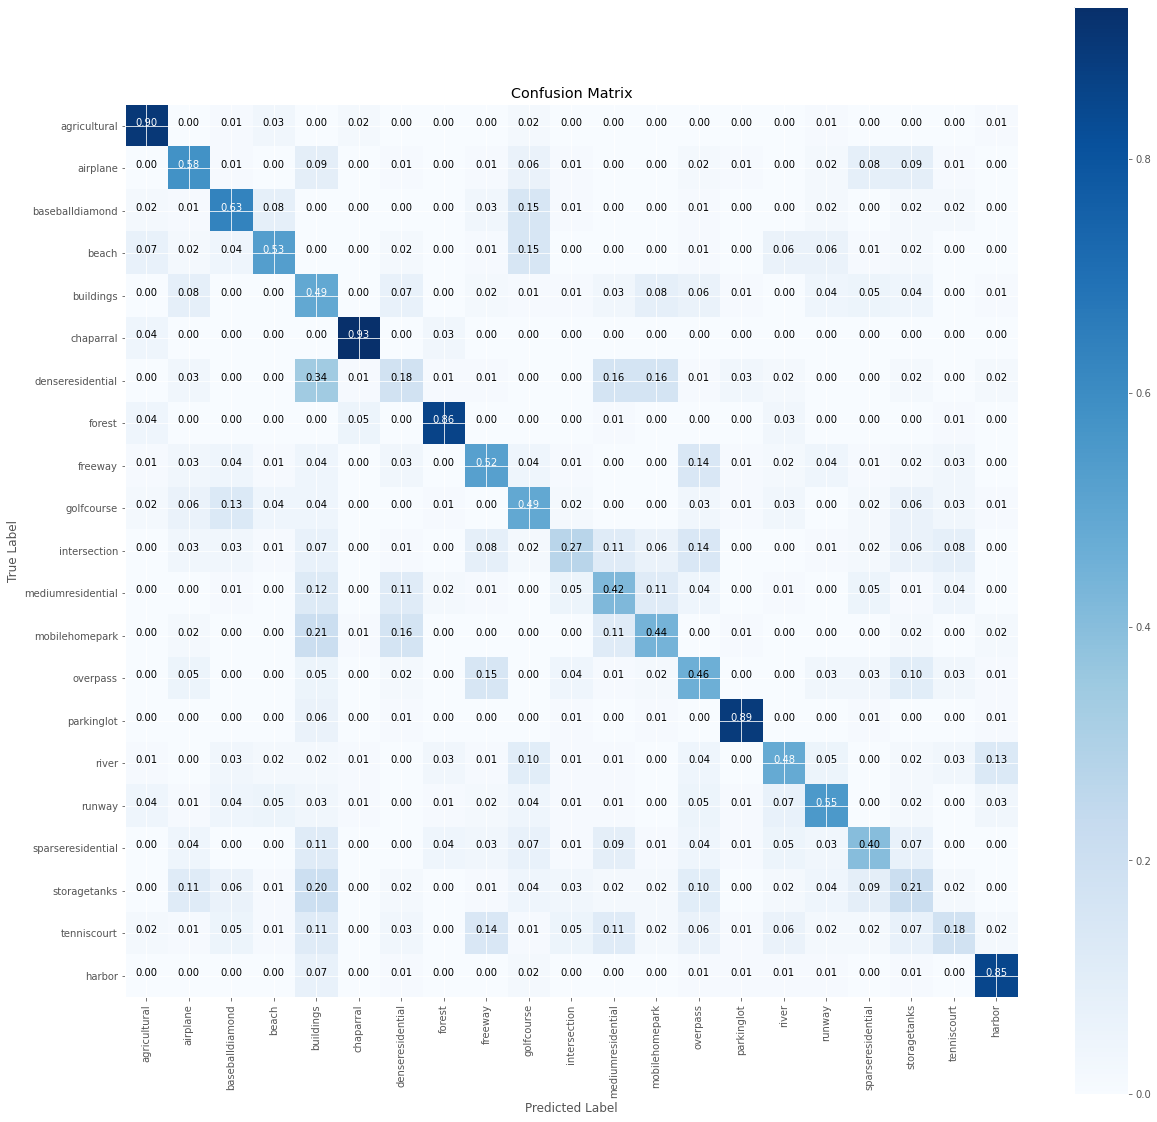

In [ ]:
val_actual = np.argmax(val_classes, axis=1)

conf_matrix = confusion_matrix(val_actual, val_predict)
np.set_printoptions(precision=2)

plt.figure()
show_conf_matrix(conf_matrix, classes=out_classes)
plt.grid(None)
plt.show()

### Make Predictions

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#Formula
# accuracy: (tp + tn) / (p + n)
RS_CNN_Accuracy = accuracy_score(val_actual, val_predict)
print('RS_CNN - Validation Accuracy: %f' % RS_CNN_Accuracy)

#Formula
# precision tp / (tp + fp)
RS_CNN_precision = precision_score(val_actual, val_predict, average="weighted")
print('RS_CNN - Precision : %f' % RS_CNN_precision)

#Formula
# recall: tp / (tp + fn)
RS_CNN_recall = recall_score(val_actual, val_predict, average="weighted")
print('RS_CNN - Recall : %f' % RS_CNN_recall)

#Formula
# f1: 2 tp / (2 tp + fp + fn)
RS_CNN_f1_sc = f1_score(val_actual, val_predict, average="weighted")
print('RS_CNN - F1 score : %f' % RS_CNN_f1_sc)

RS_CNN - Validation Accuracy: 0.536190
RS_CNN - Precision : 0.540832
RS_CNN - Recall : 0.536190
RS_CNN - F1 score : 0.530925


In [ ]:
_, model_base_acc = model.evaluate(
   test_imgs, test_classes, verbose=0)

print('Test accuracy for base:', model_base_acc) 

Test accuracy for base: 0.5742856860160828


### Save the model

In [ ]:
# model.save("/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/Custom_trained/RS_CNN_New_baseline.h5")

In [ ]:
RS_CNN_New_base_fin = load_model('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/Custom_trained/RS_CNN_New_baseline.h5')

### Calculate Inference time

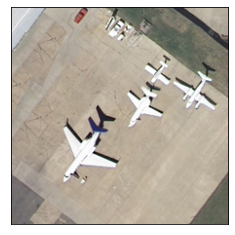

Predicted Class is: 1
Inference time is:  0.04818213900000501


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif')

# predict the class
start = time.perf_counter()
pre_class = RS_CNN_New_base_fin.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
print("Inference time is: ", ir_time)